# Bayesian Deep Learning 

In [1]:
import torch
from torch import nn
from torch.utils.cpp_extension import load
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Nice dark plotting settings
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

In [3]:
# Load C++ extensions
bnets = load(name='bayesian_nets',
             sources=['bayesian_nets.cc'],
             extra_include_paths=['../../include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             verbose=False)

In [4]:
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = nn.Linear(1, 10, bias = True)
        self.l2 = nn.Linear(10, 10, bias = True)
        self.l3 = nn.Linear(10, 1, bias = True)

    def forward(self, x):
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.l3(x)
        return x

net = Net()
jit_net = torch.jit.script(net)
jit_net.save('jit_net.pt')

In [5]:
n_tr = 7
n_val = 300

x_train, y_train, x_val, y_val = bnets.generate_data(n_tr, n_val)

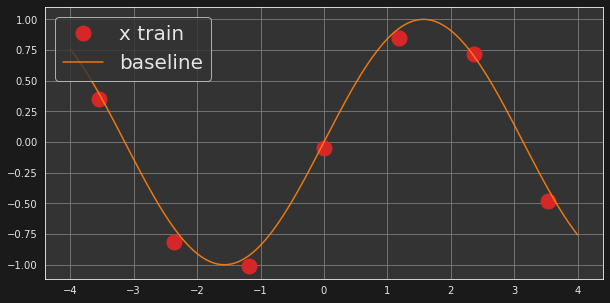

In [6]:
plt.figure(figsize=(10,5))
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train')
plt.plot(x_val.numpy(),y_val.numpy(),'C1',alpha=0.9, markersize=2, label='baseline')

plt.legend(fontsize=20)
plt.show()

In [7]:
[optim_params, adam_preds] = bnets.train_jit_module('jit_net.pt', x_train, y_train, x_val, 250)

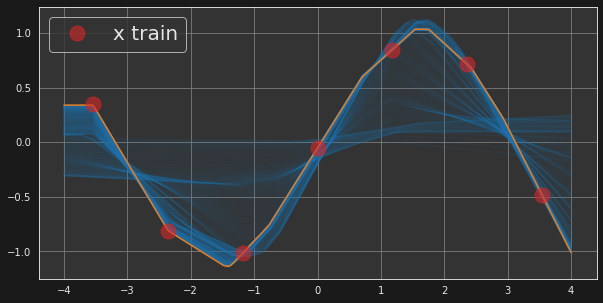

In [8]:
plt.figure(figsize=(10,5))
plt.plot(x_val.numpy(), adam_preds.numpy().squeeze().T, 'C0',alpha=0.1)
plt.plot(x_val.numpy(), adam_preds[-1].numpy().squeeze().T, 'C1',alpha=0.9)
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train',alpha=0.6)

plt.legend(fontsize=20)
plt.show()

In [13]:
sample = bnets.sample_jit_module('jit_net.pt', 'ghmc_sample_bayesian_net.pt', x_train, y_train, torch.zeros_like(optim_params),
                                 100.0, 1.0, 300, 25, 0.001)

In [14]:
posterior_mean_pred = bnets.compute_posterior_mean_prediction('jit_net.pt', x_val, sample, 2) 
bayes_pred_ = bnets.compute_bayes_predictions('jit_net.pt', x_val, sample) 

In [15]:
bayes_pred = bayes_pred_[-(bayes_pred_.shape[0] // 2):]
bayes_mean_pred = bayes_pred.mean(0)
bayes_std_pred = bayes_pred.std(0)
bayes_pstd_pred = bayes_mean_pred + bayes_std_pred
bayes_mstd_pred = bayes_mean_pred - bayes_std_pred

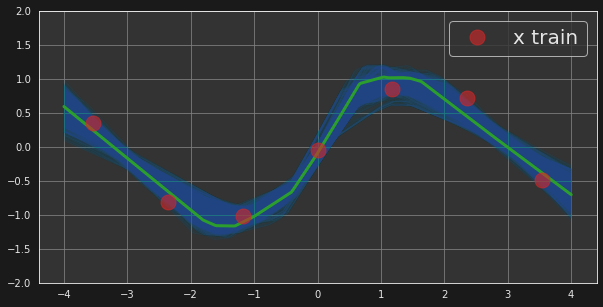

In [16]:
plt.figure(figsize=(10,5))
plt.plot(x_val.numpy(), bayes_pred.numpy().squeeze().T, 'C0',alpha=0.02)
plt.plot(x_val.numpy(), posterior_mean_pred.numpy().squeeze().T, 'C2',alpha=0.99, linewidth=3)
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train',alpha=0.6)

plt.legend(fontsize=20)
plt.ylim([-2,2])
plt.show()

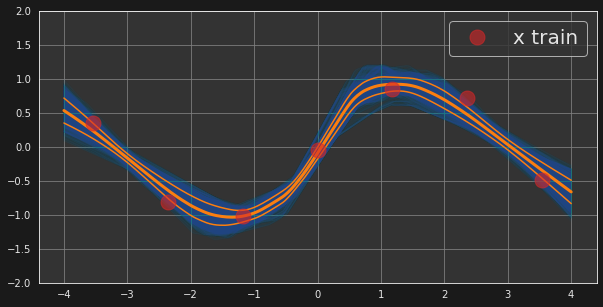

In [17]:
plt.figure(figsize=(10,5))
plt.plot(x_val.numpy(), bayes_pred.numpy().squeeze().T, 'C0',alpha=0.02)
plt.plot(x_val.numpy(), bayes_mean_pred.numpy().squeeze().T, 'C1',alpha=0.99, linewidth=3)
plt.plot(x_val.numpy(), bayes_pstd_pred.numpy().squeeze().T, 'C1',alpha=0.99)
plt.plot(x_val.numpy(), bayes_mstd_pred.numpy().squeeze().T, 'C1',alpha=0.99)
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train',alpha=0.6)
plt.legend(fontsize=20)
plt.ylim([-2,2])
plt.show()

In [18]:
y_train[-1] += 1.0

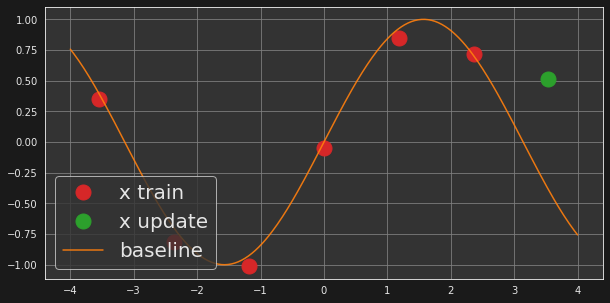

In [19]:
plt.figure(figsize=(10,5))
plt.plot(x_train[:-1].numpy(), y_train[:-1].numpy(),'.C3',markersize=30, label='x train')
plt.plot(x_train[-1:].numpy(), y_train[-1:].numpy(),'.C2',markersize=30, label='x update')
plt.plot(x_val.numpy(),y_val.numpy(),'C1',alpha=0.9, markersize=2, label='baseline')

plt.legend(fontsize=20, loc='lower left')
plt.show()

In [24]:
update_sample = bnets.sample_jit_module('jit_net.pt', 'ghmc_sample_update_bayesian_net.pt', x_train[-1:], y_train[-1:], optim_params,
                                0.1, 1.0, 50, 25, 0.001)

In [25]:
ubayes_pred = bnets.compute_bayes_predictions('jit_net.pt', x_val, update_sample) 
ubayes_mean_pred = ubayes_pred.mean(0)
ubayes_std_pred = ubayes_pred.std(0)
ubayes_pstd_pred = ubayes_mean_pred + bayes_std_pred
ubayes_mstd_pred = ubayes_mean_pred - bayes_std_pred

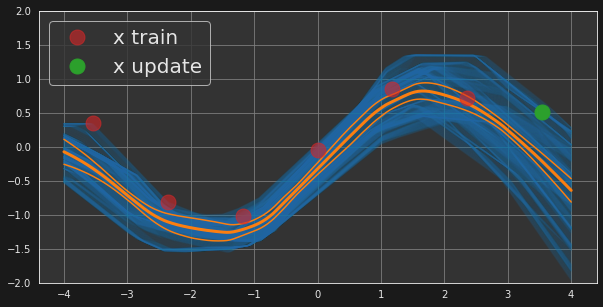

In [26]:
plt.figure(figsize=(10,5))
plt.plot(x_val.numpy(), ubayes_pred.numpy().squeeze().T, 'C0',alpha=0.05)
plt.plot(x_val.numpy(), ubayes_mean_pred.numpy().squeeze().T, 'C1',alpha=0.99, linewidth=3)
plt.plot(x_val.numpy(), ubayes_pstd_pred.numpy().squeeze().T, 'C1',alpha=0.99)
plt.plot(x_val.numpy(), ubayes_mstd_pred.numpy().squeeze().T, 'C1',alpha=0.99)
plt.plot(x_train[:-1].numpy(), y_train[:-1].numpy(),'.C3',markersize=30, label='x train',alpha=0.6)
plt.plot(x_train[-1:].numpy(), y_train[-1:].numpy(),'.C2',markersize=30, label='x update')

plt.legend(fontsize=20)
plt.ylim([-2,2])
plt.show()